# Importar las librerias
Para este ejercicio debemos usar pandas para el manejo del conjunto de datos y sklearn como libreria de ML para entrenar y evaluar los modelos

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

# EDA - Machine Predictive Maintenance Classification
Usaremos un dataset para matenimiento predictivo que fue ya preparado para un ejercicio de clasificacion, donde se debe usar los datos con dos objetivos:
1. determinar su hay falla
2. determinar el tipo de falla

las columnas son:
* Type: calidad del producto, alta (H) media (M) o baja (L))
* Air temperature [K]: Temperatura medida del ambiente
* Process temperature [K]: temperatura medida del proceso
* Rotational speed [rpm]: velocidad calculada a partir de la pontencia
* Torque [Nm]: torque
* Tool wear [min]: desgaste por minuto
* target: hay falla o no
* Failure Type: tipo de falla si la hay

Se puede visualizar y explorar mas el dataset en https://www.kaggle.com/shivamb/machine-predictive-maintenance-classification

Importamos los datos desde el CSV y vemos las primeras filas:

In [2]:
heads = ["UDI","Product ID","Type","Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Target", "Failure Type"]
df = pd.read_csv("predictive_maintenance.csv", 
                        sep=",")
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [3]:
#tambien podemos ver el tamaño de dafaframe
print(df.shape)

(10000, 10)


Como ejercicio para el analisis del dataset podriamos usar pandas para evaluar las siguientes preguntas:
* ¿Que relacion tiene el tipo (Type) de producto con la posibilidad de fallar o el tipo de falla?
* ¿Cuales son los tipos de falla?
* ¿Que variable tiene mas incidencia en cada tipo de falla?

In [4]:
failures_serie = df.drop_duplicates(subset = ["Failure Type"])["Failure Type"]
print(failures_serie)  #esto es una serie
failures_list = []
#vamos a sacar la serie en forma de lista "just in case"
for i in failures_serie:
    failures_list.append(i)
print(failures_list)

0                     No Failure
50                 Power Failure
77             Tool Wear Failure
160           Overstrain Failure
1221             Random Failures
3236    Heat Dissipation Failure
Name: Failure Type, dtype: object
['No Failure', 'Power Failure', 'Tool Wear Failure', 'Overstrain Failure', 'Random Failures', 'Heat Dissipation Failure']


Ahora el primer reto es determinar cual variable incide mas en cada tipo de falla. 

Desde el campo de la ingenieria mecanica se espera que:
* Overstrain Failure (sobreesfuerzo) se deba a un torque excesivo
* Tool Wear Failure (desgaste) se deba al desgaste acelerado de la herramienta
* Heat Dissipation Failure (perdida de calor) se evidencia en una alta temperatura ambiente o de proceso
* Power Failure (potencia) se deba a un aumento en la velocidad de rotacion y el torque P=T*w

Para hacer el analisis, pero vamos a crear un df que solo contenga la columnas y filas de interes.

In [5]:
#dfa = df.drop(['UDI', 'Product ID'], axis=1)[df["Failure Type"] != "No Failure"] #en caso de querar dejar solo las fallas
dfa = df.drop(['UDI', 'Product ID'], axis=1)
type_number = []
for i in dfa["Type"]:
    if i == "L":
        type_number.append(0)
    elif i == "M":
        type_number.append(1)
    else:
        type_number.append(2)
dfa["Type"] = type_number #cambiamos las etiquetas por numeros
print(dfa.head(5))

   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     1                298.1                    308.6                    1551   
1     0                298.2                    308.7                    1408   
2     0                298.1                    308.5                    1498   
3     0                298.2                    308.6                    1433   
4     0                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure  


### ¿Cual variable indice mas en cada falla?

In [6]:
#quitamos en type y target porque no tiene sentido promediarlos
dfa.drop(["Type", "Target"], axis=1).groupby(by="Failure Type").mean()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Failure Type,,,,,
Heat Dissipation Failure,302.567857,310.799107,1337.964286,52.778571,107.339286
No Failure,299.972855,309.994343,1540.324389,39.624316,106.678927
Overstrain Failure,299.867949,310.051282,1354.243590,56.878205,208.217949
Power Failure,300.075789,309.954737,1763.968421,48.514737,101.884211
Random Failures,300.766667,310.755556,1489.444444,43.522222,119.888889
Tool Wear Failure,300.288889,310.164444,1570.666667,37.226667,216.555556


### ¿Cual es la relacion entre la calidad del producto y la posibilidad de falla?

In [7]:
#no nos interesa ver las no fallas porque crearia sesgo
dfa[df["Failure Type"] != "No Failure"].groupby(by=["Failure Type","Type"])["Type"].count()
#tarea: calcular el porcentaje de fallas por calidad y para cada tipo de falla

Failure Type              Type
Heat Dissipation Failure  0       74
                          1       30
                          2        8
Overstrain Failure        0       73
                          1        4
                          2        1
Power Failure             0       59
                          1       31
                          2        5
Random Failures           0       12
                          1        2
                          2        4
Tool Wear Failure         0       25
                          1       14
                          2        6
Name: Type, dtype: int64

In [8]:
sfa = dfa[df["Failure Type"] != "No Failure"].groupby(by=["Failure Type","Type"])["Type"].count()
failures_list2 = failures_list
failures_list2.remove("No Failure")
for i in failures_list2:
    print(i)
    for j in range(3):
        print(str(j) + ":  " + str(round(sfa[i][j]/(sfa[i][0]+sfa[i][1]+sfa[i][2]),3)))    

Power Failure
0:  0.621
1:  0.326
2:  0.053
Tool Wear Failure
0:  0.556
1:  0.311
2:  0.133
Overstrain Failure
0:  0.936
1:  0.051
2:  0.013
Random Failures
0:  0.667
1:  0.111
2:  0.222
Heat Dissipation Failure
0:  0.661
1:  0.268
2:  0.071


Este utimo analisis nos lleva a una conclusion muy importante y es que las piezas de menor calidad siempre van a fallar de forma mucho mas frecuente, en especial por sobre carga.

Mas a fondo se debe hacer el analisis sobre el costo/beneficio de tener una pieza de mejor calidad. 

Se debe evitar aplicar mucho torque cuando se usen piezas de menos calidad. ¿por que?

### ¿Cuales son las fallas mas frecuentes?

In [9]:
sfa2 = dfa[df["Failure Type"] != "No Failure"].groupby(by=["Failure Type"])["Failure Type"]
sfa2.count()/sfa2.count().count()

Failure Type
Heat Dissipation Failure    22.4
Overstrain Failure          15.6
Power Failure               19.0
Random Failures              3.6
Tool Wear Failure            9.0
Name: Failure Type, dtype: float64

# Preparacion de los datos para el modelo


In [10]:
feature_cols = ["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]
target_col = ["Target"]
X = dfa[feature_cols]
y = dfa[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Entrenar y evaluar el modelo
Para entrenar el modelo, primer creamos un objeto <DecisionTreeClassifier> sobre la cual se puede especificar varios parametros como se detalla en el API https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
    
Despues usamos el metodo <fit> para realizar el entrenamiento entregando como argumentos los features (X) y los targets (y).

In [11]:
clf = DecisionTreeClassifier() #crear el classifier con todo por defecto
clf = clf.fit(X_train,y_train) #entrenar el modelo con los datos de entrenamiento

Para usar el modelo con datos nuevos, se debe usar el metodo predict, que resive una lista o arreglo de datos a evaluar y retorna un arreglo de respuestas. El modelo siempre se debe evaluar sobre datos que no esten en el conjunto de entrenamiento, por eso previamente separamos un subconjunto llamado X_test y y_test

In [12]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Evaluar el modelo

In [13]:
metrics.accuracy_score(y_pred, y_test)

0.981

Esto parece una prediccion muy buena, pero es peligrosa porque la mayoria de nuestros datos son de un mismo target, es decir, los datos de entrenamiento estan desvalanceados y esto puede hacer que el modelo se ajuste por la cantidad y no por las metricas deseadas.

In [14]:
y_train[y_train["Target"]==0].count()/y_train.count() #porcentaje de datos que son 0

Target    0.966
dtype: float64

Para mejorar esta situacion, podemos equilibrar los datos dejando un 40% para fallas y un 60% para no fallas

In [15]:
#sacamos un df solo con las fallas
dfa_1 = dfa[df["Target"] != 0]
#sacamos un df solo con las no fallas pero 1.2 veces mas grande que el dfa_1
dfa_2 = dfa[df["Target"] == 0].sample(int(len(dfa_1)*1.2))
#concatenamos para crear el definitivo
dfa_3 = pd.concat([dfa_1, dfa_2])
X = dfa_3[feature_cols]
y = dfa_3[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
X_test

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
5703,302.3,311.7,1456,45.4,130
5341,303.5,312.8,1404,55.8,84
4494,302.6,310.4,1649,30.1,62
8609,297.4,308.3,1475,40.5,222
2169,299.5,309.1,1415,49.2,8
...,...,...,...,...,...
9414,298.1,308.6,1354,53.9,207
3101,299.8,309.0,1467,37.3,193
6540,301.4,310.7,1368,63.7,92
9259,298.2,309.0,1694,28.0,5


In [16]:
clf = DecisionTreeClassifier() #crear el classifier con todo por defecto
clf = clf.fit(X_train,y_train) #entrenar el modelo con los datos de entrenamiento

In [17]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0], dtype=int64)

In [18]:
metrics.accuracy_score(y_pred, y_test)

0.8705357142857143

vemos que la precision se redujo, pero es normal la reducir tanto el dataset.

# Random Forest
Ahora aplicaremos lo mismo para el random forest

In [19]:
clf_2 = RandomForestClassifier(max_depth=2, random_state=0)

In [20]:
clf_2.fit(X_train, y_train.values.ravel()) #notar que se debe usar .values.ravel()

RandomForestClassifier(max_depth=2, random_state=0)

In [21]:
y_pred = clf_2.predict(X_test)

In [22]:
metrics.accuracy_score(y_pred, y_test)

0.8125

In [23]:
j=0.1
for i in range(10):
    j = j+0.2
    dfa_1 = dfa[df["Target"] != 0]
    dfa_2 = dfa[df["Target"] == 0].sample(int(len(dfa_1)*j))
    dfa_3 = pd.concat([dfa_1, dfa_2])
    X = dfa_3[feature_cols]
    y = dfa_3[target_col]
    clf_1 = DecisionTreeClassifier(max_depth=3, random_state=0) #crear el classifier con todo por defecto
    clf_2 = RandomForestClassifier(max_depth=3, random_state=0)
    print("relacion ----- " + str(len(dfa_1)) + "/" + str(len(dfa_2)))
    print("DT: " + str(cross_val_score(clf_1, X, y, cv = 5).mean()))
    print("RF: " + str(cross_val_score(clf_2, X, y.values.ravel(), cv = 5).mean()))

relacion ----- 339/101
DT: 0.8340909090909092
RF: 0.9068181818181819
relacion ----- 339/169
DT: 0.8365560085420306
RF: 0.8483401281304601
relacion ----- 339/237
DT: 0.7501799100449775
RF: 0.8699250374812593
relacion ----- 339/305
DT: 0.764014050387597
RF: 0.8634811046511628
relacion ----- 339/372
DT: 0.8031419284940412
RF: 0.8397714961095243
relacion ----- 339/440
DT: 0.7228122415219189
RF: 0.8087510339123243
relacion ----- 339/508
DT: 0.7638496345283675
RF: 0.8146884789418726
relacion ----- 339/576
DT: 0.8557377049180328
RF: 0.8382513661202186
relacion ----- 339/644
DT: 0.7650367761317727
RF: 0.8393245623122345
relacion ----- 339/711
DT: 0.7914285714285715
RF: 0.8514285714285714


## Evaluar el rendimiento

In [38]:
j=0.1
x_axis = []
y1_axis = []
y2_axis = []
for i in range(30):
    #vamos a cambiar el grupo de entrenamiento aumentando gradualmente el numero de no fallas sobre el de fallas
    j = j+0.2
    dfa_1 = dfa[df["Target"] != 0]
    dfa_test = dfa_1[:39]
    dfa_2 = dfa[df["Target"] == 0].sample(int(len(dfa_1)*j))
    #sacamos para evaluar con un grupo de 39 datos solo de las fallas
    dfa_train = pd.concat([dfa_1[39:], dfa_2])  #creamos el grupo para entrenamiento
    X_train = dfa_train[feature_cols]
    y_train = dfa_train[target_col]
    X_test = dfa_test[feature_cols]
    y_test = dfa_test[target_col]
    #creamos los modelos, aqui se puede variar la profundidad limite del arbol
    clf_1 = DecisionTreeClassifier(max_depth=2, random_state=0)
    clf_1 = clf_1.fit(X_train,y_train) #entrenar
    clf_2 = RandomForestClassifier(max_depth=2, random_state=0)
    clf_2 = clf_2.fit(X_train,y_train.values.ravel()) #entrenar
    print("relacion ----- " + str(len(dfa_1)) + "/" + str(len(dfa_2)))
    x_axis.append(len(dfa_2)/len(dfa_1))
    m1 = clf_1.predict(X_test)
    m2 = clf_2.predict(X_test)
    print("DT: " + str(metrics.accuracy_score(m1,y_test)))
    y1_axis.append(metrics.accuracy_score(m1, y_test))
    print("RF: " + str(metrics.accuracy_score(m2, y_test)))
    y2_axis.append(metrics.accuracy_score(m2, y_test))

relacion ----- 339/101
DT: 0.5897435897435898
RF: 0.9487179487179487
relacion ----- 339/169
DT: 0.6153846153846154
RF: 0.7948717948717948
relacion ----- 339/237
DT: 0.5897435897435898
RF: 0.6923076923076923
relacion ----- 339/305
DT: 0.23076923076923078
RF: 0.6666666666666666
relacion ----- 339/372
DT: 0.5897435897435898
RF: 0.5641025641025641
relacion ----- 339/440
DT: 0.5897435897435898
RF: 0.5128205128205128
relacion ----- 339/508
DT: 0.15384615384615385
RF: 0.46153846153846156
relacion ----- 339/576
DT: 0.6923076923076923
RF: 0.5384615384615384
relacion ----- 339/644
DT: 0.5897435897435898
RF: 0.46153846153846156
relacion ----- 339/711
DT: 0.15384615384615385
RF: 0.48717948717948717
relacion ----- 339/779
DT: 0.15384615384615385
RF: 0.46153846153846156
relacion ----- 339/847
DT: 0.15384615384615385
RF: 0.46153846153846156
relacion ----- 339/915
DT: 0.15384615384615385
RF: 0.3333333333333333
relacion ----- 339/983
DT: 0.15384615384615385
RF: 0.46153846153846156
relacion ----- 339/10

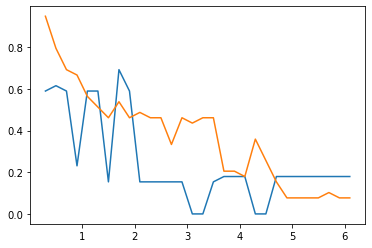

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_axis, y1_axis, color='tab:blue')
ax.plot(x_axis, y2_axis, color='tab:orange')
plt.show()

[Text(157.97432432432433, 206.56799999999998, 'X[2] <= 1386.5\ngini = 0.495\nsamples = 521\nvalue = [286, 235]'),
 Text(88.22432432432433, 184.824, 'X[0] <= 301.95\ngini = 0.286\nsamples = 185\nvalue = [32, 153]'),
 Text(55.800000000000004, 163.07999999999998, 'X[3] <= 52.75\ngini = 0.395\nsamples = 107\nvalue = [29, 78]'),
 Text(30.162162162162165, 141.336, 'X[4] <= 206.0\ngini = 0.466\nsamples = 27\nvalue = [17, 10]'),
 Text(24.129729729729732, 119.592, 'X[0] <= 301.55\ngini = 0.308\nsamples = 21\nvalue = [17, 4]'),
 Text(12.064864864864866, 97.848, 'X[4] <= 202.5\ngini = 0.111\nsamples = 17\nvalue = [16, 1]'),
 Text(6.032432432432433, 76.10399999999998, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(18.0972972972973, 76.10399999999998, 'X[1] <= 309.95\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(12.064864864864866, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(24.129729729729732, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(

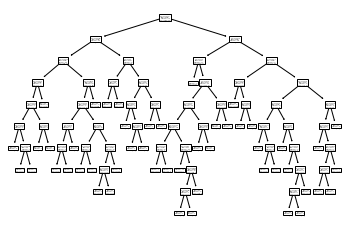

In [43]:
tree.plot_tree(clf)